# Kernel density estimation

In [22]:
# Import all libraries needed for the exploration

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd #this is how we usually import pandas
import numpy as np #this is how we usually import numpy
import sys #only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number

from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate

# Enable inline plotting
%matplotlib inline

In [23]:
# Supress some warnings:
import warnings
warnings.filterwarnings('ignore')

In [24]:
print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Numpy version ' + np.__version__)
print('Matplotlib version ' + matplotlib.__version__)
print('Seaborn version ' + sns.__version__)

Python version 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
Pandas version 0.24.2
Numpy version 1.16.2
Matplotlib version 3.0.3
Seaborn version 0.9.0


## Training data

In [27]:
data = pd.read_csv('../data/train.csv')

In [28]:
x = data['Age']

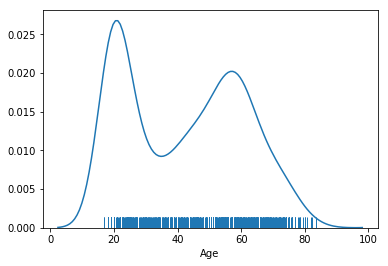

In [29]:
sns.distplot(x, hist=False, rug=True);

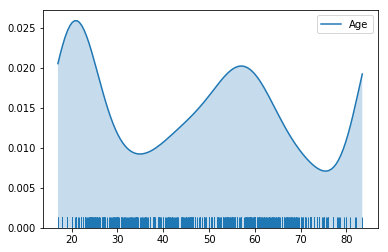

In [31]:
sns.kdeplot(x, shade=True, cut=0)
sns.rugplot(x)
plt.show()

### Discretization of Age variable
Quantile-based discretization function. Discretize variable into equal-sized buckets based on rank or based on sample quantiles. For example 1000 values for 10 quantiles would produce a Categorical object indicating quantile membership for each data point.

In [35]:
pd.qcut(data['Age'], 8).head(2)

0    (16.999, 20.0]
1    (16.999, 20.0]
Name: Age, dtype: category
Categories (8, interval[float64]): [(16.999, 20.0] < (20.0, 21.0] < (21.0, 30.06] < (30.06, 44.0] < (44.0, 52.515] < (52.515, 58.0] < (58.0, 64.0] < (64.0, 83.458]]

In [34]:
discr = pd.qcut(data['Age'], 8, labels=["a1","a2","a3", "a4", "a5", "a6", "a7", "a8"])
discr

0       a1
1       a1
2       a4
3       a8
4       a7
5       a4
6       a3
7       a3
8       a7
9       a4
10      a7
11      a7
12      a1
13      a1
14      a8
15      a4
16      a7
17      a7
18      a1
19      a4
20      a5
21      a7
22      a1
23      a4
24      a1
25      a6
26      a1
27      a1
28      a1
29      a3
        ..
1055    a7
1056    a6
1057    a8
1058    a1
1059    a5
1060    a3
1061    a1
1062    a7
1063    a3
1064    a7
1065    a8
1066    a7
1067    a8
1068    a4
1069    a8
1070    a3
1071    a1
1072    a4
1073    a7
1074    a4
1075    a1
1076    a3
1077    a4
1078    a8
1079    a6
1080    a4
1081    a8
1082    a4
1083    a8
1084    a8
Name: Age, Length: 1085, dtype: category
Categories (8, object): [a1 < a2 < a3 < a4 < a5 < a6 < a7 < a8]

### Explore the data

In [5]:
# Check the number of data points in the data set
print('No observations:', len(data))
# Check the number of features in the data set
print('No variables:', len(data.columns))
# Check the data types
print(data.dtypes.unique())

No observations: 1085
No variables: 152
[dtype('int64') dtype('O') dtype('float64')]


In [6]:
data.shape

(1085, 152)

In [7]:
data.columns

Index(['SubjectID', 'Source', 'ID', 'Sex', 'Height', 'Weight', 'FieldStrength',
       'Handedness', 'Measure:volume', 'Left-Lateral-Ventricle',
       ...
       'rh_superiortemporal_thickness', 'rh_supramarginal_thickness',
       'rh_frontalpole_thickness', 'rh_temporalpole_thickness',
       'rh_transversetemporal_thickness', 'rh_insula_thickness',
       'rh_MeanThickness_thickness', 'BrainSegVolNotVent', 'eTIV_y', 'Age'],
      dtype='object', length=152)

In [8]:
for i, col in enumerate(data.columns, start=0):
    print(i, col)

0 SubjectID
1 Source
2 ID
3 Sex
4 Height
5 Weight
6 FieldStrength
7 Handedness
8 Measure:volume
9 Left-Lateral-Ventricle
10 Left-Inf-Lat-Vent
11 Left-Cerebellum-White-Matter
12 Left-Cerebellum-Cortex
13 Left-Thalamus-Proper
14 Left-Caudate
15 Left-Putamen
16 Left-Pallidum
17 3rd-Ventricle
18 4th-Ventricle
19 Brain-Stem
20 Left-Hippocampus
21 Left-Amygdala
22 CSF
23 Left-Accumbens-area
24 Left-VentralDC
25 Left-vessel
26 Left-choroid-plexus
27 Right-Lateral-Ventricle
28 Right-Inf-Lat-Vent
29 Right-Cerebellum-White-Matter
30 Right-Cerebellum-Cortex
31 Right-Thalamus-Proper
32 Right-Caudate
33 Right-Putamen
34 Right-Pallidum
35 Right-Hippocampus
36 Right-Amygdala
37 Right-Accumbens-area
38 Right-VentralDC
39 Right-vessel
40 Right-choroid-plexus
41 5th-Ventricle
42 WM-hypointensities
43 Left-WM-hypointensities
44 Right-WM-hypointensities
45 non-WM-hypointensities
46 Left-non-WM-hypointensities
47 Right-non-WM-hypointensities
48 Optic-Chiasm
49 CC_Posterior
50 CC_Mid_Posterior
51 CC_Central

In [9]:
# We may have some categorical features, let's check them
data.select_dtypes(include=['O']).columns.tolist()

['Source',
 'ID',
 'Sex',
 'FieldStrength',
 'lh.aparc.thickness',
 'rh.aparc.thickness']

In [10]:
# Check any number of columns with NaN
print(data.isnull().any().sum(), ' / ', len(data.columns))
# Check number of data points with any NaN
print(data.isnull().any(axis=1).sum(), ' / ', len(data))

4  /  152
1085  /  1085


### Select features and targets

In [11]:
features = data.iloc[:,9:-1].columns.tolist()
target = data.iloc[:,-1].name

In [12]:
all_lh_features = [
 'CSF', 'CC_Posterior', 'CC_Mid_Posterior', 'CC_Central', 'CC_Mid_Anterior', 'CC_Anterior', 'EstimatedTotalIntraCranialVol',
 'Left-Lateral-Ventricle',
 'Left-Inf-Lat-Vent',
 'Left-Cerebellum-White-Matter',
 'Left-Cerebellum-Cortex',
 'Left-Thalamus-Proper',
 'Left-Caudate',
 'Left-Putamen',
 'Left-Pallidum',
 'Left-Hippocampus',
 'Left-Amygdala',
 'Left-Accumbens-area',
 'Left-VentralDC',
 'Left-vessel',
 'Left-choroid-plexus',
 'Left-WM-hypointensities',
 'Left-non-WM-hypointensities',
 'lhCortexVol',
 'lhCerebralWhiteMatterVol',            
 'lhSurfaceHoles',  
 'lh.aparc.thickness',
 'lh_bankssts_thickness',
 'lh_caudalanteriorcingulate_thickness',
 'lh_caudalmiddlefrontal_thickness',
 'lh_cuneus_thickness',
 'lh_entorhinal_thickness',
 'lh_fusiform_thickness',
 'lh_inferiorparietal_thickness',
 'lh_inferiortemporal_thickness',
 'lh_isthmuscingulate_thickness',
 'lh_lateraloccipital_thickness',
 'lh_lateralorbitofrontal_thickness',
 'lh_lingual_thickness',
 'lh_medialorbitofrontal_thickness',
 'lh_middletemporal_thickness',
 'lh_parahippocampal_thickness',
 'lh_paracentral_thickness',
 'lh_parsopercularis_thickness',
 'lh_parsorbitalis_thickness',
 'lh_parstriangularis_thickness',
 'lh_pericalcarine_thickness',
 'lh_postcentral_thickness',
 'lh_posteriorcingulate_thickness',
 'lh_precentral_thickness',
 'lh_precuneus_thickness',
 'lh_rostralanteriorcingulate_thickness',
 'lh_rostralmiddlefrontal_thickness',
 'lh_superiorfrontal_thickness',
 'lh_superiorparietal_thickness',
 'lh_superiortemporal_thickness',
 'lh_supramarginal_thickness',
 'lh_frontalpole_thickness',
 'lh_temporalpole_thickness',
 'lh_transversetemporal_thickness',
 'lh_insula_thickness',
 'lh_MeanThickness_thickness'
 ]

In [13]:
data_lh = data[all_lh_features]

In [14]:
data_lh.describe().T

,count,mean,std,min,25%,50%,75%,max
CSF,1085.0,1.032723e+03,275.511828,550.900000,8.495000e+02,9.899000e+02,1.154000e+03,3.135600e+03
CC_Posterior,1085.0,9.987616e+02,165.006387,259.400000,8.902000e+02,9.960000e+02,1.085900e+03,1.824100e+03
CC_Mid_Posterior,1085.0,5.644137e+02,133.126229,115.500000,4.795000e+02,5.486000e+02,6.324000e+02,1.447200e+03
CC_Central,1085.0,6.605299e+02,182.178230,255.700000,5.111000e+02,6.562000e+02,7.948000e+02,1.289500e+03
CC_Mid_Anterior,1085.0,6.463947e+02,178.891557,247.400000,5.046000e+02,6.348000e+02,7.690000e+02,1.294700e+03
CC_Anterior,1085.0,8.903859e+02,158.324487,451.100000,7.865000e+02,8.744000e+02,9.783000e+02,1.650500e+03
EstimatedTotalIntraCranialVol,1085.0,1.515452e+06,165943.653773,955810.846787,1.395718e+06,1.504274e+06,1.626013e+06,1.978181e+06
Left-Lateral-Ventricle,1085.0,8.635934e+03,5515.628037,2284.700000,5.113900e+03,7.219100e+03,1.039490e+04,5.612140e+04
Left-Inf-Lat-Vent,1085.0,3.151976e+02,206.390677,24.600000,1.900000e+02,2.604000e+02,3.873000e+02,2.396500e+03
Left-Cerebellum-White-Matter,1085.0,1.519431e+04,2548.795235,8065.000000,1.358100e+04,1.483760e+04,1.637510e+04,3.164460e+04


In [15]:
dropcolumns = [
    'EstimatedTotalIntraCranialVol',
    'CSF', 
    'CC_Posterior', 
    'CC_Mid_Posterior', 
    'CC_Central', 
    'CC_Mid_Anterior', 
    'CC_Anterior'   
]

df_lh = data_lh.drop(dropcolumns, axis=1)
df_lh

,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus-Proper,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,Left-Amygdala,...,lh_rostralmiddlefrontal_thickness,lh_superiorfrontal_thickness,lh_superiorparietal_thickness,lh_superiortemporal_thickness,lh_supramarginal_thickness,lh_frontalpole_thickness,lh_temporalpole_thickness,lh_transversetemporal_thickness,lh_insula_thickness,lh_MeanThickness_thickness
0,5968.4,212.0,12717.4,54979.7,8170.7,3773.4,5204.9,1956.4,4150.9,1515.2,...,2.560,2.924,2.379,2.953,2.642,3.043,3.662,2.460,3.062,2.63478
1,12256.1,241.9,15603.7,50793.1,8513.6,4153.9,5317.9,2330.4,3971.8,1692.1,...,2.530,2.981,2.333,2.817,2.715,2.763,3.699,2.395,3.242,2.60656
2,4764.0,202.1,13745.1,44080.0,7312.0,3320.8,4137.5,1797.2,3465.7,1377.4,...,2.551,2.882,2.286,2.790,2.710,2.676,4.050,2.225,2.902,2.57094
3,10770.0,532.2,13814.3,50342.0,7367.5,2726.2,4771.3,2122.2,4046.3,1476.0,...,2.418,2.516,2.180,2.780,2.662,2.880,3.712,2.179,2.566,2.45492
4,6773.7,517.0,15662.8,54779.1,7156.6,3357.3,4940.3,2010.9,4109.7,1435.1,...,2.302,2.505,2.062,2.579,2.453,2.736,3.646,1.956,2.889,2.36957
5,7624.0,242.9,14844.7,58079.1,8214.1,2806.9,4084.5,1999.0,4245.7,1607.9,...,2.467,2.677,1.995,2.899,2.401,2.364,3.690,2.240,3.110,2.39852
6,6704.6,194.1,15954.4,59217.9,8339.7,3241.6,5318.9,2165.5,4349.9,1732.6,...,2.442,2.750,2.209,2.693,2.463,2.861,3.733,2.067,3.098,2.48641
7,6180.0,145.6,15200.8,63160.4,8401.1,3298.0,4838.4,2035.7,4224.4,1487.2,...,2.363,2.767,2.024,2.956,2.518,2.531,4.114,2.135,3.052,2.43681
8,8390.7,164.2,14077.6,53929.8,6794.8,2736.6,4461.0,1881.6,4606.9,1760.1,...,2.467,2.784,2.118,2.687,2.398,2.916,3.453,2.211,2.510,2.42755
9,7342.8,334.8,14736.9,55986.5,7323.9,3312.5,3421.6,1908.2,4574.3,1655.2,...,2.705,2.932,2.206,2.896,2.757,3.062,3.770,2.513,3.013,2.57659


In [18]:
target

'Age'

There are several options available for computing kernel density estimates in Python. The question of the optimal KDE implementation for any situation, however, is not entirely straightforward, and depends a lot on what your particular goals are. Here are the four KDE implementations I'm aware of in the SciPy/Scikits stack:

 - In SciPy: [`gaussian_kde`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html)

 - In Statsmodels: KDEUnivariate and KDEMultivariate (See an example [here](http://www.statsmodels.org/devel/generated/statsmodels.nonparametric.kernel_density.KDEMultivariate.html)).

 - In Scikit-learn: KernelDensity (See further examples [here](https://scikit-learn.org/stable/modules/density.html#kernel-density-estimation)).

Each has advantages and disadvantages, and each has its area of applicability. I'll start with a table summarizing the strengths and weaknesses of each, before discussing each feature in more detail and running some simple benchmarks to gauge their computational cost:

## KDE in Python
https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/

In [8]:
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate


def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)


def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)
    
    
def kde_statsmodels_m(x, x_grid, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, bw=bandwidth * np.ones_like(x),
                          var_type='c', **kwargs)
    return kde.pdf(x_grid)


def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


kde_funcs = [kde_statsmodels_u, kde_statsmodels_m, kde_scipy, kde_sklearn]
kde_funcnames = ['Statsmodels-U', 'Statsmodels-M', 'Scipy', 'Scikit-learn']

print("Package Versions:")
import sklearn; print("  scikit-learn:", sklearn.__version__)
import scipy; print("  scipy:", scipy.__version__)
import statsmodels; print("  statsmodels:", statsmodels.__version__)

Package Versions:
  scikit-learn: 0.20.3
  scipy: 1.2.1
  statsmodels: 0.9.0


IndexError: boolean index did not match indexed array along dimension 0; dimension is 500 but corresponding boolean dimension is 1

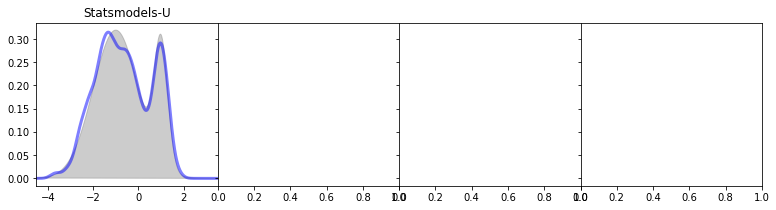

In [7]:
from scipy.stats.distributions import norm

# The grid we'll use for plotting
x_grid = np.linspace(-4.5, 3.5, 1000)

# Draw points from a bimodal distribution in 1D
np.random.seed(0)
x = np.concatenate([norm(-1, 1.).rvs(400),
                    norm(1, 0.3).rvs(100)])
pdf_true = (0.8 * norm(-1, 1).pdf(x_grid) +
            0.2 * norm(1, 0.3).pdf(x_grid))

# Plot the three kernel density estimates
fig, ax = plt.subplots(1, 4, sharey=True,
                       figsize=(13, 3))
fig.subplots_adjust(wspace=0)

for i in range(4):
    pdf = kde_funcs[i](x, x_grid, bandwidth=0.2)
    ax[i].plot(x_grid, pdf, color='blue', alpha=0.5, lw=3)
    ax[i].fill(x_grid, pdf_true, ec='gray', fc='gray', alpha=0.4)
    ax[i].set_title(kde_funcnames[i])
    ax[i].set_xlim(-4.5, 3.5)
    
from IPython.display import HTML
HTML("<font color='#666666'>Gray = True underlying distribution</font><br>"
     "<font color='6666ff'>Blue = KDE model distribution (500 pts)</font>")

C:\Users\arvid\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


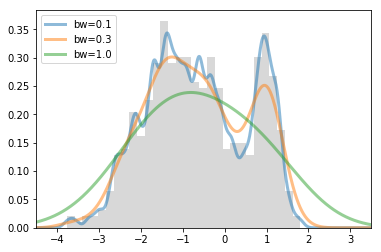

In [9]:
fig, ax = plt.subplots()
for bandwidth in [0.1, 0.3, 1.0]:
    ax.plot(x_grid, kde_sklearn(x, x_grid, bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.5)
ax.hist(x, 30, fc='gray', histtype='stepfilled', alpha=0.3, normed=True)
ax.set_xlim(-4.5, 3.5)
ax.legend(loc='upper left')

### Discretization of Age variable
Quantile-based discretization function. Discretize variable into equal-sized buckets based on rank or based on sample quantiles. For example 1000 values for 10 quantiles would produce a Categorical object indicating quantile membership for each data point.

In [25]:
pd.qcut(data['Age'], 8).head(1)

0    (16.999, 20.0]
Name: Age, dtype: category
Categories (8, interval[float64]): [(16.999, 20.0] < (20.0, 21.0] < (21.0, 30.06] < (30.06, 44.0] < (44.0, 52.515] < (52.515, 58.0] < (58.0, 64.0] < (64.0, 83.458]]

#### Columns with missing values

In [31]:
def missing(dff):
    print (round((dff.isnull().sum() * 100/ len(dff)),4).sort_values(ascending=False))

In [32]:
missing(df_lh)

lh_MeanThickness_thickness               0.0
Left-choroid-plexus                      0.0
lh_entorhinal_thickness                  0.0
lh_cuneus_thickness                      0.0
lh_caudalmiddlefrontal_thickness         0.0
lh_caudalanteriorcingulate_thickness     0.0
lh_bankssts_thickness                    0.0
lh.aparc.thickness                       0.0
lhSurfaceHoles                           0.0
lhCerebralWhiteMatterVol                 0.0
lhCortexVol                              0.0
Left-non-WM-hypointensities              0.0
Left-WM-hypointensities                  0.0
Left-vessel                              0.0
lh_inferiorparietal_thickness            0.0
Left-VentralDC                           0.0
Left-Accumbens-area                      0.0
Left-Amygdala                            0.0
Left-Hippocampus                         0.0
Left-Pallidum                            0.0
Left-Putamen                             0.0
Left-Caudate                             0.0
Left-Thala

#### How to remove columns with too many missing values in Python
https://stackoverflow.com/questions/45515031/how-to-remove-columns-with-too-many-missing-values-in-python

In [98]:
def rmissingvaluecol(dff,threshold):
    l = []
    l = list(dff.drop(dff.loc[:,list((100*(dff.isnull().sum()/len(dff.index))>=threshold))].columns, 1).columns.values)
    print("# Columns having more than %s percent missing values:"%threshold,(dff.shape[1] - len(l)))
    print("Columns:\n",list(set(list((dff.columns.values))) - set(l)))
    return l

In [99]:
#Here threshold is 10% which means we are going to drop columns having more than 10% of missing values
rmissingvaluecol(data,10)

# Columns having more than 10 percent missing values: 4
Columns:
 ['Height', 'FieldStrength', 'Weight', 'Handedness']


['SubjectID',
 'Source',
 'ID',
 'Sex',
 'Measure:volume',
 'Left-Lateral-Ventricle',
 'Left-Inf-Lat-Vent',
 'Left-Cerebellum-White-Matter',
 'Left-Cerebellum-Cortex',
 'Left-Thalamus-Proper',
 'Left-Caudate',
 'Left-Putamen',
 'Left-Pallidum',
 '3rd-Ventricle',
 '4th-Ventricle',
 'Brain-Stem',
 'Left-Hippocampus',
 'Left-Amygdala',
 'CSF',
 'Left-Accumbens-area',
 'Left-VentralDC',
 'Left-vessel',
 'Left-choroid-plexus',
 'Right-Lateral-Ventricle',
 'Right-Inf-Lat-Vent',
 'Right-Cerebellum-White-Matter',
 'Right-Cerebellum-Cortex',
 'Right-Thalamus-Proper',
 'Right-Caudate',
 'Right-Putamen',
 'Right-Pallidum',
 'Right-Hippocampus',
 'Right-Amygdala',
 'Right-Accumbens-area',
 'Right-VentralDC',
 'Right-vessel',
 'Right-choroid-plexus',
 '5th-Ventricle',
 'WM-hypointensities',
 'Left-WM-hypointensities',
 'Right-WM-hypointensities',
 'non-WM-hypointensities',
 'Left-non-WM-hypointensities',
 'Right-non-WM-hypointensities',
 'Optic-Chiasm',
 'CC_Posterior',
 'CC_Mid_Posterior',
 'CC_Ce

In [100]:
# Now create new dataframe excluding these columns
l = rmissingvaluecol(data,10)
data1 = data[l]

# Columns having more than 10 percent missing values: 4
Columns:
 ['Height', 'FieldStrength', 'Weight', 'Handedness']


In [101]:
# missing(data[features])

#### Correlations between features and target

In [104]:
correlations = {}
for f in features:
    data_temp = data1[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]

In [105]:
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
lh_insula_thickness vs Age,-0.572424
rh_insula_thickness vs Age,-0.547666
rh_parsorbitalis_thickness vs Age,-0.501914
lh_parsorbitalis_thickness vs Age,-0.464792
Left-Lateral-Ventricle vs Age,0.458784
Right-Lateral-Ventricle vs Age,0.446086
rh_parahippocampal_thickness vs Age,-0.214836
lh_parahippocampal_thickness vs Age,-0.173509


#### We can see that the top 5 features are the most correlated features with the target "Age"

In [108]:
y = data.loc[:,['lh_insula_thickness','rh_insula_thickness',target]].sort_values(target, ascending=True).values
x = np.arange(y.shape[0])

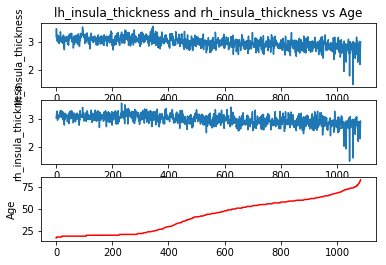

In [109]:
%matplotlib inline
plt.subplot(3,1,1)
plt.plot(x,y[:,0])
plt.title('lh_insula_thickness and rh_insula_thickness vs Age')
plt.ylabel('lh_insula_thickness')

plt.subplot(3,1,2)
plt.plot(x,y[:,1])
plt.ylabel('rh_insula_thickness')

plt.subplot(3,1,3)
plt.plot(x,y[:,2],'r')
plt.ylabel("Age")

plt.show()

### Predicting Age

In [115]:
# Train a simple linear regression model
regr = linear_model.LinearRegression()
new_data = data[features]

In [116]:
X = new_data.values
y = data.Age.values

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2)

In [120]:
regr.fit(X_train, y_train)
print(regr.predict(X_test))

[ 40.26215822  52.73759521  32.38092553  69.94745346  40.74674538
  42.81256113  26.33642016  18.99090684  40.61615371  51.19628677
  45.97370323  44.36776157  19.84677273  56.20778796  63.02045595
  25.38893895  52.34309984  45.74582733  22.62640226  45.14721014
  37.14349031  28.32441254  24.10945518  29.30161616  37.93751988
  28.23567073  34.7513464   31.39147949  36.13830631  58.25515543
  35.57164764  45.69784681  45.15737594  30.06739509  34.12306674
  51.66018966  47.71524995  58.81758066  55.65393097  52.51658456
  44.18512012  30.79376463  32.22232595  38.51828841  52.96832978
  46.92018209  46.12072676  25.46805051  47.12062023  39.03335715
  30.05147109  38.79004408  35.03470988  43.46331263  36.32689369
  48.90200731  31.73084835  29.29195648 114.73773053  38.24888887
  26.11832624  34.7462788   25.45241279  74.5893491   32.78911877
  24.48251944  56.45219477  36.12498349  75.3288535   44.41877628
  37.98615202  43.54654305  40.85339155  52.58007581  78.77423028
  29.59495

In [121]:
regr.score(X_test,y_test)

0.4750674148517645

In [122]:
# Calculate the Root Mean Squared Error
print("RMSE: %.2f"
      % math.sqrt(np.mean((regr.predict(X_test) - y_test) ** 2)))

RMSE: 12.77


In [123]:
# Let's try XGboost algorithm to see if we can get better results
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [125]:
traindf, testdf = train_test_split(X_train, test_size = 0.3)
xgb.fit(X_train,y_train)

[22:23:30] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.08, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.75, verbosity=1)

In [126]:
predictions = xgb.predict(X_test)
print(explained_variance_score(predictions,y_test))

0.32469110931920553


### This is worse than a simple regression model

We can use `.describe()` to calculate simple **descriptive statistics** for the dataset (rounding to 3 decimals):

In [128]:
new_data.describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
lh_parsorbitalis_thickness,1085.0,2.762,0.214,1.599,2.629,2.762,2.905,3.462
rh_parsorbitalis_thickness,1085.0,2.771,0.214,1.745,2.632,2.775,2.914,3.505
lh_parahippocampal_thickness,1085.0,2.735,0.298,1.589,2.543,2.737,2.937,3.709
rh_parahippocampal_thickness,1085.0,2.700,0.248,1.780,2.538,2.711,2.859,3.471
Left-Lateral-Ventricle,1085.0,8635.934,5515.628,2284.700,5113.900,7219.100,10394.900,56121.400
Right-Lateral-Ventricle,1085.0,7851.851,5212.003,2222.600,4639.000,6403.600,9455.400,56343.400
lh_insula_thickness,1085.0,2.972,0.194,1.498,2.869,2.979,3.102,3.546
rh_insula_thickness,1085.0,2.988,0.197,1.486,2.871,2.996,3.125,3.586


Computing the **pairwise correlation of columns** (features). Method could be ‘pearson’ (default), ‘kendall’, or ‘spearman’. 

In [129]:
new_data.corr().round(2)

,lh_parsorbitalis_thickness,rh_parsorbitalis_thickness,lh_parahippocampal_thickness,rh_parahippocampal_thickness,Left-Lateral-Ventricle,Right-Lateral-Ventricle,lh_insula_thickness,rh_insula_thickness
lh_parsorbitalis_thickness,1.00,0.59,0.20,0.26,-0.27,-0.29,0.50,0.48
rh_parsorbitalis_thickness,0.59,1.00,0.22,0.29,-0.26,-0.27,0.52,0.52
lh_parahippocampal_thickness,0.20,0.22,1.00,0.70,-0.29,-0.25,0.26,0.25
rh_parahippocampal_thickness,0.26,0.29,0.70,1.00,-0.27,-0.29,0.31,0.33
Left-Lateral-Ventricle,-0.27,-0.26,-0.29,-0.27,1.00,0.92,-0.32,-0.37
Right-Lateral-Ventricle,-0.29,-0.27,-0.25,-0.29,0.92,1.00,-0.32,-0.36
lh_insula_thickness,0.50,0.52,0.26,0.31,-0.32,-0.32,1.00,0.73
rh_insula_thickness,0.48,0.52,0.25,0.33,-0.37,-0.36,0.73,1.00


In [131]:
new_data.describe()

,lh_parsorbitalis_thickness,rh_parsorbitalis_thickness,lh_parahippocampal_thickness,rh_parahippocampal_thickness,Left-Lateral-Ventricle,Right-Lateral-Ventricle,lh_insula_thickness,rh_insula_thickness
count,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000,1085.000000
mean,2.762101,2.770634,2.735071,2.699907,8635.933733,7851.850507,2.972150,2.988305
std,0.214068,0.213805,0.298453,0.248156,5515.628037,5212.003164,0.194034,0.197194
min,1.599000,1.745000,1.589000,1.780000,2284.700000,2222.600000,1.498000,1.486000
25%,2.629000,2.632000,2.543000,2.538000,5113.900000,4639.000000,2.869000,2.871000
50%,2.762000,2.775000,2.737000,2.711000,7219.100000,6403.600000,2.979000,2.996000
75%,2.905000,2.914000,2.937000,2.859000,10394.900000,9455.400000,3.102000,3.125000
max,3.462000,3.505000,3.709000,3.471000,56121.400000,56343.400000,3.546000,3.586000


Splitting the object (iris DataFrame) **into groups** (species)

In [133]:
grouped = data.groupby('Sex')

In [134]:
grouped.groups

{'F': Int64Index([   0,    1,    2,    7,    8,   13,   16,   17,   19,   20,
             ...
             1073, 1075, 1076, 1078, 1079, 1080, 1081, 1082, 1083, 1084],
            dtype='int64', length=611),
 'M': Int64Index([   3,    4,    5,    6,    9,   10,   11,   12,   14,   15,
             ...
             1052, 1053, 1054, 1060, 1061, 1066, 1067, 1071, 1074, 1077],
            dtype='int64', length=474)}

Describe the group-wise `PetalLength` summary statistics

In [135]:
print('Age:')
grouped['Age'].describe()

Age:


,count,mean,std,min,25%,50%,75%,max
Sex,,,,,,,,
F,611.0,42.937321,18.917609,17.0,21.0,46.006845,59.0,81.941136
M,474.0,41.099283,18.111956,17.0,21.0,41.000000,56.0,83.457906


Iterating through the grouped data is very natural

In [136]:
for name, group in grouped:
    print(name,':')
    print(group.describe().round(2).head(3))

F :
       SubjectID  Height  Weight  Handedness  Measure:volume  \
count     611.00  202.00  202.00       81.00           611.0   
mean      764.03  163.23   65.93       94.94             0.0   
std       450.63    7.77   16.09       15.50             0.0   

       Left-Lateral-Ventricle  Left-Inf-Lat-Vent  \
count                  611.00             611.00   
mean                  7897.59             289.78   
std                   5118.12             191.02   

       Left-Cerebellum-White-Matter  Left-Cerebellum-Cortex  \
count                        611.00                  611.00   
mean                       14641.69                51303.14   
std                         2275.35                 5657.52   

       Left-Thalamus-Proper  ...  rh_superiortemporal_thickness  \
count                611.00  ...                         611.00   
mean                7344.60  ...                           2.81   
std                  895.28  ...                           0.20   

       r

**Group-wise feature correlations**

In [137]:
data.groupby('Age').corr().round(3)

SubjectID  Height  Weight  \
Age                                                                          
17.000000 SubjectID                                    1.0     NaN     NaN   
          Height                                       NaN     NaN     NaN   
          Weight                                       NaN     NaN     NaN   
          Handedness                                   NaN     NaN     NaN   
          Measure:volume                               NaN     NaN     NaN   
          Left-Lateral-Ventricle                      -1.0     NaN     NaN   
          Left-Inf-Lat-Vent                           -1.0     NaN     NaN   
          Left-Cerebellum-White-Matter                 1.0     NaN     NaN   
          Left-Cerebellum-Cortex                       1.0     NaN     NaN   
          Left-Thalamus-Proper                        -1.0     NaN     NaN   
          Left-Caudate                                -1.0     NaN     NaN   
          Left-Putamen                                -1.0     NaN     NaN   
          Left-Pallidum                               -1.0     NaN     NaN   
          3rd-Ventricle                               -1.0     NaN     NaN   
          4th-Ventricle                               -1.0     NaN     NaN   
          Brain-Stem                                  -1.0     NaN     NaN   
          Left-Hippocampus                             1.0     NaN     NaN   
          Left-Amygdala                               -1.0     NaN     NaN   
          CSF                                          1.0     NaN     NaN   
          Left-Accumbens-area                         -1.0     NaN     NaN   
          Left-VentralDC                              -1.0     NaN     NaN   
          Left-vessel                                 -1.0     NaN     NaN   
          Left-choroid-plexus                          1.0     NaN     NaN   
          Right-Lateral-Ventricle                     -1.0     NaN     NaN   
          Right-Inf-Lat-Vent                           1.0     NaN     NaN   
          Right-Cerebellum-White-Matter                1.0     NaN     NaN   
          Right-Cerebellum-Cortex                      1.0     NaN     NaN   
          Right-Thalamus-Proper                       -1.0     NaN     NaN   
          Right-Caudate                               -1.0     NaN     NaN   
          Right-Putamen                               -1.0     NaN     NaN   
...                                                    ...     ...     ...   
83.457906 rh_inferiortemporal_thickness                NaN     NaN     NaN   
          rh_isthmuscingulate_thickness                NaN     NaN     NaN   
          rh_lateraloccipital_thickness                NaN     NaN     NaN   
          rh_lateralorbitofrontal_thickness            NaN     NaN     NaN   
          rh_lingual_thickness                         NaN     NaN     NaN   
          rh_medialorbitofrontal_thickness             NaN     NaN     NaN   
          rh_middletemporal_thickness                  NaN     NaN     NaN   
          rh_parahippocampal_thickness                 NaN     NaN     NaN   
          rh_paracentral_thickness                     NaN     NaN     NaN   
          rh_parsopercularis_thickness                 NaN     NaN     NaN   
          rh_parsorbitalis_thickness                   NaN     NaN     NaN   
          rh_parstriangularis_thickness                NaN     NaN     NaN   
          rh_pericalcarine_thickness                   NaN     NaN     NaN   
          rh_postcentral_thickness                     NaN     NaN     NaN   
          rh_posteriorcingulate_thickness              NaN     NaN     NaN   
          rh_precentral_thickness                      NaN     NaN     NaN   
          rh_precuneus_thickness                       NaN     NaN     NaN   
          rh_rostralanteriorcingulate_thickness        NaN     NaN     NaN   
          rh_rostralmiddlefrontal_thickness            NaN     NaN     

DataFrame has an `assign()` method that allows you to easily create new columns that are potentially derived from existing columns.

In [33]:
iris.assign(sepal_ratio = iris['SepalWidth'] / iris['SepalLength']).head().round(3)

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name,sepal_ratio
0,5.1,3.5,1.4,0.2,Iris-setosa,0.686
1,4.9,3.0,1.4,0.2,Iris-setosa,0.612
2,4.7,3.2,1.3,0.2,Iris-setosa,0.681
3,4.6,3.1,1.5,0.2,Iris-setosa,0.674
4,5.0,3.6,1.4,0.2,Iris-setosa,0.720


In the example above, we inserted a precomputed value. <br>
We can also pass in a function of one argument to be evaluated on the DataFrame being assigned to.

In [34]:
iris.assign(sepal_ratio = lambda x: (x['SepalWidth'] /
                                     x['SepalLength'])).head().round(3)

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name,sepal_ratio
0,5.1,3.5,1.4,0.2,Iris-setosa,0.686
1,4.9,3.0,1.4,0.2,Iris-setosa,0.612
2,4.7,3.2,1.3,0.2,Iris-setosa,0.681
3,4.6,3.1,1.5,0.2,Iris-setosa,0.674
4,5.0,3.6,1.4,0.2,Iris-setosa,0.720


`assign` always returns a copy of the data, leaving the original DataFrame untouched, e.g.

In [35]:
iris.head(2)

,SepalLength,SepalWidth,PetalLength,PetalWidth,Name
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa


Passing a callable, as opposed to an actual value to be inserted, is useful when you don’t have a reference to the DataFrame at hand. This is common when using assign``  in a chain of operations. For example, we can limit the DataFrame to just those observations with a Sepal Length greater than 5, calculate the ratio, and plot:

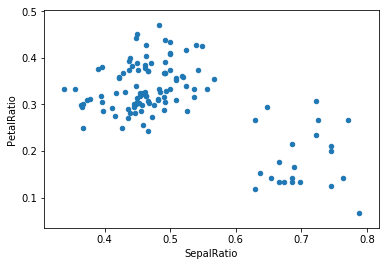

In [36]:
(iris.query('SepalLength > 5')
 .assign(SepalRatio = lambda x: x.SepalWidth / x.SepalLength,
         PetalRatio = lambda x: x.PetalWidth / x.PetalLength)
 .plot(kind='scatter', x='SepalRatio', y='PetalRatio'))

### Classification

*Organizing data as X and y before classification*

In [ ]:
from sklearn.preprocessing import LabelEncoder

# dfX5Y = pd.read_csv('../results/02_X5Y.csv', sep=',')
# print(dfX5Y.info())
# print(dfX5Y.describe())
# dfX5Y

# Featuer importance XGBoost:
# X = df.loc[:, ['CC_Mid_Anterior_w3', 'BrainSegVol-to-eTIV_w3', 'CSF_w2']] # Top three important features
# Featuer importance RF (Strrop_3):
X = df.loc[:, ['BrainSegVol-to-eTIV_w3', 'CC_Mid_Anterior_w3', 'ic04-ic02']] # Top three important features
# Featuer importance RF predicrting Stroop_1_R_3:
# X = df.loc[:, ['ic09-ic06', 'ic10-ic01', 'ic05-ic03']] # Top three important features
# Featuer importance RF predicrting Stroop_2_R_3:
# X = df.loc[:, ['WM-hypointensities_w3', 'ic17-ic04', 'Left-vessel_w3']] # Top three important features
# X = df.loc[:, ['BrainSegVol-to-eTIV_w3', 'ic04-ic02']] # Two important features
# X = df.loc[:, ['BrainSegVol-to-eTIV_w3', 'CC_Mid_Anterior_w3']] # Top two important features
Y = df.loc[:, ['Stroop_3_cat']]
y = Y.as_matrix().ravel()
np.unique(y)
X.columns

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import preprocessing

# X = dfX5Y.loc[:, dfX5Y.columns != 'grp']      # Top five important connections
# X = dfX5Y.loc[:, ['ic09-ic02', 'ic04-ic01']]   # Top two important connections
# X = df.loc[:, ['LatVent_w2', 'LatVent_w3', 'ic09-ic02', 'ic04-ic01']]
# X = df.loc[:, ['LatVent_w3', 'ic09-ic02']]
# X = df.loc[:, ['LatVent_w2', 'LatVent_w3']]
# Y = df.loc[:, ['Stroop_3_cat']]

# X = df.loc[:, ['BrainSegVol-to-eTIV_w3', 'CC_Mid_Anterior_w3', 'ic04-ic02']]
# Y = df.loc[:, ['Stroop_3_cat']]
# y = Y.as_matrix().ravel()

rs = 42 # random_state (42)
hls = 3 # MLP hidden layer size (3 or 4)
# https://stackoverflow.com/questions/37659970/how-does-sklearn-compute-the-precision-score-metric
myaverage = 'weighted' # For multilabel classification  'micro', 'macro', 'samples', 'weighted'
# see: https://stackoverflow.com/questions/37659970/how-does-sklearn-compute-the-precision-score-metric

# http://scikit-learn.org/stable/modules/neural_networks_supervised.html
# Class MLPClassifier implements a multi-layer perceptron (MLP) algorithm that 
# trains using Backpropagation.

# So what about size of the hidden layer(s)--how many neurons? 
# There are some empirically-derived rules-of-thumb, of these, the most 
# commonly relied on is 'the optimal size of the hidden layer is usually 
# between the size of the input and size of the output layers'. 
# Jeff Heaton, author of Introduction to Neural Networks in Java offers a few more.
#
# In sum, for most problems, one could probably get decent performance (even without 
# a second optimization step) by setting the hidden layer configuration using j
# ust two rules: 
#  (i) number of hidden layers equals one; and 
# (ii) the number of neurons in that layer is the mean of the neurons in the 
#      input and output layers.
# Compute the precision
# The precision is the ratio tp / (tp + fp) where tp is the number of true positives and 
# fp the number of false positives. The precision is intuitively the ability of the 
# classifier not to label as positive a sample that is negative.

# Compute the recall
# The recall is the ratio tp / (tp + fn) where tp is the number of true positives and 
# fn the number of false negatives. The recall is intuitively the ability of the 
# classifier to find all the positive samples.

# Compute the F1 score, also known as balanced F-score or F-measure
# The F1 score can be interpreted as a weighted average of the precision and recall, 
# where an F1 score reaches its best value at 1 and worst score at 0. 
# The relative contribution of precision and recall to the F1 score are equal. 
# The formula for the F1 score is:
#    F1 = 2 * (precision * recall) / (precision + recall)
# In the multi-class and multi-label case, this is the weighted average of the F1 score of each class.

pipe_clf1 = Pipeline([
    ('scl', StandardScaler()),
    #('pca', PCA(n_components=2)),
    ('clf1', LogisticRegression(C=1., solver='saga', n_jobs=1, 
                                multi_class='multinomial', random_state=rs))])

pipe_clf2 = Pipeline([
    ('scl', StandardScaler()),
    #('pca', PCA(n_components=2)),
    ('clf2', MLPClassifier(hidden_layer_sizes=(hls, ),   # =(100, )  ; =(4, )
                          activation='relu', solver='adam',
                          alpha=0.0001, batch_size='auto', learning_rate='constant',
                          learning_rate_init=0.001, power_t=0.5, max_iter=5000,
                          shuffle=True, random_state=rs, tol=0.0001, verbose=False,
                          warm_start=False, momentum=0.9, nesterovs_momentum=True,
                          early_stopping=False, validation_fraction=0.1,
                          beta_1=0.9, beta_2=0.999, epsilon=1e-08))])

# pipe_clf3 = Pipeline([
#     ('scl', StandardScaler()),
#     #('pca', PCA(n_components=2)),
#     ('clf3', RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None,
#                                   min_samples_split=2, min_samples_leaf=1,
#                                   min_weight_fraction_leaf=0.0, max_features='auto',
#                                   max_leaf_nodes=None,     #  min_impurity_split=1e-07,
#                                   bootstrap=True, oob_score=False, n_jobs=1,
#                                   random_state=rs, verbose=0, warm_start=False,
#                                   class_weight=None))])
# pipe_clf3 = Pipeline([
#     ('scl', StandardScaler()),
#     #('pca', PCA(n_components=2)),
#     ('clf3', GradientBoostingClassifier(init=None, learning_rate=0.05, loss='deviance',
#                                         max_depth=None, max_features=None, max_leaf_nodes=None,
#                                         min_samples_leaf=1, min_samples_split=2,
#                                         min_weight_fraction_leaf=0.0, n_estimators=100,
#                                         presort='auto', random_state=rs, subsample=1.0, verbose=0,
#                                         warm_start=False)

pipe_clf3 = Pipeline([
    ('scl', StandardScaler()),
    #('pca', PCA(n_components=2)),
    ('clf3', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
                           gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
                           min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
                           objective='multi:softprob', reg_alpha=0, reg_lambda=1,
                           scale_pos_weight=1, seed=rs, silent=True, subsample=1))])
     
pipe_clf4 = Pipeline([
    ('scl', StandardScaler()),
    #('pca', PCA(n_components=2)),
    ('clf4', SVC(C=1.0, probability=True, random_state=rs))])
#    ('clf4', SVC(C=1.0, random_state=rs))])
    
pipe_clf5 = Pipeline([
    ('scl', StandardScaler()),
    #('pca', PCA(n_components=2)),
    ('clf5', KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='kd_tree', 
                           leaf_size=30, p=2, metric='minkowski', 
                           metric_params=None, n_jobs=1))])

pipe_clf_vote =  Pipeline([
#    ('scl', StandardScaler()),
    ('clf_vote', VotingClassifier(
        estimators=[('lr', pipe_clf1), 
                 ('mlp', pipe_clf2),
                 ('rf', pipe_clf3),
                 ('svc', pipe_clf4),
                 ('knn', pipe_clf5)],
     voting = 'soft'))])
#     voting = 'hard'))])

scores1_acc, scores2_acc, scores3_acc, scores4_acc, scores5_acc, scores_vote_acc = [], [], [], [], [], []
scores1_pre, scores2_pre, scores3_pre, scores4_pre, scores5_pre, scores_vote_pre = [], [], [], [], [], []
scores1_rec, scores2_rec, scores3_rec, scores4_rec, scores5_rec, scores_vote_rec = [], [], [], [], [], []
scores1_f1, scores2_f1, scores3_f1, scores4_f1, scores5_f1, scores_vote_f1 = [], [], [], [], [], []

n_splits = 10  # k=10
# n_splits = X.shape[0]   # i.e.  Leave One Out strategy
# for train_index, test_index in LeaveOneOut.split(X):

k=1
for train_index, test_index in \
StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rs).split(X,y):
    print("Fold number:", k)
    #print("\nTRUE class:\n", list(y[test_index]))
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    
    #clf1 = LogisticRegression
    print(" - LogisticRegression")
    pipe_clf1.fit(X_train, y_train)
    scores1_acc.append(accuracy_score(y_test, pipe_clf1.predict(X_test)))
    scores1_pre.append(precision_score(y_test, pipe_clf1.predict(X_test), average=myaverage))
    scores1_rec.append(recall_score(y_test, pipe_clf1.predict(X_test), average=myaverage))
    scores1_f1.append(f1_score(y_test, pipe_clf1.predict(X_test), average=myaverage))
    print('    Precision: %.2f' % (precision_score(y_test, pipe_clf1.predict(X_test), average=myaverage)))
    print('    Recall: %.2f' % (recall_score(y_test, pipe_clf1.predict(X_test), average=myaverage)))
    #print("LR predicted:\n", list(pipe_clf1.predict(X_test)))
    
    #clf2 = MLPClassifier
    print(" - MLPClassifier")
    pipe_clf2.fit(X_train, y_train)
    scores2_acc.append(accuracy_score(y_test, pipe_clf2.predict(X_test)))
    scores2_pre.append(precision_score(y_test, pipe_clf2.predict(X_test), average=myaverage))
    scores2_rec.append(recall_score(y_test, pipe_clf2.predict(X_test), average=myaverage))
    scores2_f1.append(f1_score(y_test, pipe_clf2.predict(X_test), average=myaverage))
    print('    Precision: %.2f' % (precision_score(y_test, pipe_clf2.predict(X_test), average=myaverage)))
    print('    Recall: %.2f' % (recall_score(y_test, pipe_clf2.predict(X_test), average=myaverage)))
    #print("MLP predicted:\n", list(pipe_clf2.predict(X_test)))
    
    #clf3 = RandomForestClassifier
    #print(" - RandomForestClassifier")
    #clf3 = XGBoost
    print(" - XGBoost")
    pipe_clf3.fit(X_train, y_train)
    scores3_acc.append(accuracy_score(y_test, pipe_clf3.predict(X_test)))
    scores3_pre.append(precision_score(y_test, pipe_clf3.predict(X_test), average=myaverage))
    scores3_rec.append(recall_score(y_test, pipe_clf3.predict(X_test), average=myaverage))
    scores3_f1.append(f1_score(y_test, pipe_clf3.predict(X_test), average=myaverage))
    print('    Precision: %.2f' % (precision_score(y_test, pipe_clf3.predict(X_test), average=myaverage)))
    print('    Recall: %.2f' % (recall_score(y_test, pipe_clf3.predict(X_test), average=myaverage)))
    #print("RF predicted:\n", list(pipe_clf3.predict(X_test)))
    #print("XGB predicted:\n", list(pipe_clf3.predict(X_test)))
    
    #clf4 = svm.SVC()
    print(" - svm/SVC")
    pipe_clf4.fit(X_train, y_train)
    scores4_acc.append(accuracy_score(y_test, pipe_clf4.predict(X_test)))
    scores4_pre.append(precision_score(y_test, pipe_clf4.predict(X_test), average=myaverage))
    scores4_rec.append(recall_score(y_test, pipe_clf4.predict(X_test), average=myaverage))
    scores4_f1.append(f1_score(y_test, pipe_clf4.predict(X_test), average=myaverage))
    print('    Precision: %.2f' % (precision_score(y_test, pipe_clf4.predict(X_test), average=myaverage)))
    print('    Recall: %.2f' % (recall_score(y_test, pipe_clf4.predict(X_test), average=myaverage)))
    #print("SVM predicted:\n", list(pipe_clf4.predict(X_test)))
    
        #clf5 = KNeighborsClassifier
    print(" - KNN")
    pipe_clf5.fit(X_train, y_train)
    scores5_acc.append(accuracy_score(y_test, pipe_clf5.predict(X_test)))
    scores5_pre.append(precision_score(y_test, pipe_clf5.predict(X_test), average=myaverage))
    scores5_rec.append(recall_score(y_test, pipe_clf5.predict(X_test), average=myaverage))
    scores5_f1.append(f1_score(y_test, pipe_clf5.predict(X_test), average=myaverage))
    #print("KNN predicted:\n", list(pipe_clf5.predict(X_test)))
    
    #clf_vote = VotingClassifier
    print(" - VotingClassifier")
    pipe_clf_vote.fit(X_train, y_train)
    scores_vote_acc.append(accuracy_score(y_test, pipe_clf_vote.predict(X_test)))
    scores_vote_pre.append(precision_score(y_test, pipe_clf_vote.predict(X_test), average=myaverage))
    scores_vote_rec.append(recall_score(y_test, pipe_clf_vote.predict(X_test), average=myaverage))
    scores_vote_f1.append(f1_score(y_test, pipe_clf_vote.predict(X_test), average=myaverage))
    print('    Precision: %.2f' % (precision_score(y_test, pipe_clf_vote.predict(X_test), average=myaverage)))
    print('    Recall: %.2f' % (recall_score(y_test, pipe_clf_vote.predict(X_test), average=myaverage)))
    k=k+1
    
print('\nPredictors:')
print('X.columns = %s' % list(X.columns))

print('\nOutcome:')
print(pd.qcut(df['Stroop_3_R_3'], 3).head(0))
print(np.unique(y))

print('\nSome hyperparameters:')
print("MLP hidden_layer_size = %d" % (hls))
print("random_state = %d" % (rs))
print("score average = '%s'" % (myaverage))

print("\nLR : CV accuracy = %.3f +-%.3f (k=%d)" % (np.mean(scores1_acc), np.std(scores1_acc), n_splits))
print("MLP: CV accuracy = %.3f +-%.3f (k=%d)" % (np.mean(scores2_acc), np.std(scores2_acc), n_splits))
# print("RF : CV accuracy = %.3f +-%.3f (k=%d)" % (np.mean(scores3_acc), np.std(scores3_acc), n_splits))
print("XGB : CV accuracy = %.3f +-%.3f (k=%d)" % (np.mean(scores3_acc), np.std(scores3_acc), n_splits))
print("SVM: CV accuracy = %.3f +-%.3f (k=%d)" % (np.mean(scores4_acc), np.std(scores4_acc), n_splits))
print("KNN: CV accuracy = %.3f +-%.3f (k=%d)" % (np.mean(scores5_acc), np.std(scores5_acc), n_splits))
print("Voting: CV accuracy = %.3f +-%.3f (k=%d)" % (np.mean(scores_vote_acc), np.std(scores_vote_acc), n_splits))

print("\nLR : CV precision = %.3f +-%.3f (k=%d)" % (np.mean(scores1_pre), np.std(scores1_pre), n_splits))
print("MLP: CV precision = %.3f +-%.3f (k=%d)" % (np.mean(scores2_pre), np.std(scores2_pre), n_splits))
print("XGB : CV precision = %.3f +-%.3f (k=%d)" % (np.mean(scores3_pre), np.std(scores3_pre), n_splits))
print("SVM: CV precision = %.3f +-%.3f (k=%d)" % (np.mean(scores4_pre), np.std(scores4_pre), n_splits))
print("KNN: CV precision = %.3f +-%.3f (k=%d)" % (np.mean(scores5_pre), np.std(scores5_pre), n_splits))
print("Voting: CV precision = %.3f +-%.3f (k=%d)" % (np.mean(scores_vote_pre), np.std(scores_vote_pre), n_splits))

print("\nLR : CV recall = %.3f +-%.3f (k=%d)" % (np.mean(scores1_rec), np.std(scores1_rec), n_splits))
print("MLP: CV recall = %.3f +-%.3f (k=%d)" % (np.mean(scores2_rec), np.std(scores2_rec), n_splits))
print("XGB : CV recall = %.3f +-%.3f (k=%d)" % (np.mean(scores3_rec), np.std(scores3_rec), n_splits))
print("SVM: CV recall = %.3f +-%.3f (k=%d)" % (np.mean(scores4_rec), np.std(scores4_rec), n_splits))
print("KNN: CV recall = %.3f +-%.3f (k=%d)" % (np.mean(scores5_rec), np.std(scores5_rec), n_splits))
print("Voting: CV recall = %.3f +-%.3f (k=%d)" % (np.mean(scores_vote_rec), np.std(scores_vote_rec), n_splits))

print("\nLR : CV F1-score = %.3f +-%.3f (k=%d)" % (np.mean(scores1_f1), np.std(scores1_f1), n_splits))
print("MLP: CV F1-score = %.3f +-%.3f (k=%d)" % (np.mean(scores2_f1), np.std(scores2_f1), n_splits))
print("XGB : CV F1-score = %.3f +-%.3f (k=%d)" % (np.mean(scores3_f1), np.std(scores3_f1), n_splits))
print("SVM: CV F1-score = %.3f +-%.3f (k=%d)" % (np.mean(scores4_f1), np.std(scores4_f1), n_splits))
print("KNN: CV F1-score = %.3f +-%.3f (k=%d)" % (np.mean(scores5_f1), np.std(scores5_f1), n_splits))
print("Voting: CV F1-score = %.3f +-%.3f (k=%d)" % (np.mean(scores_vote_f1), np.std(scores_vote_f1), n_splits))